# 1) Setup

In [7]:
!python -V

Python 3.8.3


In [8]:
pip install pymongo

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install pymongo[srv]

Note: you may need to restart the kernel to use updated packages.


## 1a) Modules

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np

import pymongo
from pymongo import MongoClient
from datetime import datetime
print("done")

done


## 1b) Retrieve Data from MongoDB

In [4]:
#define my database and collection
cluster = MongoClient("mongodb://127.0.0.1:27017/?readPreference=primary&appname=MongoDB%20Compass&ssl=false")
db = cluster["Rokos2021"]
collection = db["walmart_targeted"]
print("done")

done


In [5]:
#filter & store as pandas dataframe
results = collection.find({"_meta.inserted_at": {"$gte": datetime(2021,2,20,9,0,0),
                                "$lte":datetime(2021,2,28,9,0,0)}, 
                                "origin": {"$ne": None}, 
                                "edge_id": {"$ne": None}, 
                                "target":{"$ne":None},
                                "succeeded":True})

#convert to dataframe format
df = pd.DataFrame(list(results))
print("done")


done


In [6]:
#show dataframe
df.head(2)

,_id,origin,target,succeeded,run_id,date_finished,policy_goal,agent,_meta,is_final,edge_id,action,date_started,operation_time,topological_map,final_node
0,60355f5ae58b9f729ea1d688,WayPoint112,WayPoint82,True,b09bd134-ea6f-44bc-80fe-53d3dd41f62e,1970-01-01 00:00:12.801,WayPoint60,/robot_2/rapport_navigation,{'inserted_at': 2021-02-23 20:02:34.101000},False,WayPoint112_WayPoint82,move_base,1970-01-01 00:00:07.609,5.192,walmart,WayPoint82
1,60355f5a0c5936f239914148,WayPoint113,WayPoint89,True,b09bd134-ea6f-44bc-80fe-53d3dd41f62e,1970-01-01 00:00:12.921,WayPoint95,/robot_3/rapport_navigation,{'inserted_at': 2021-02-23 20:02:34.448000},False,WayPoint113_WayPoint89,move_base,1970-01-01 00:00:07.801,5.120,walmart,WayPoint89


# 1c) Select data

In [7]:
#remove data where policy_goal = target
#we previously removed null & unsuccessful entries
df = df[ df["policy_goal"] != df["target"] ]
df.head(2)

,_id,origin,target,succeeded,run_id,date_finished,policy_goal,agent,_meta,is_final,edge_id,action,date_started,operation_time,topological_map,final_node
0,60355f5ae58b9f729ea1d688,WayPoint112,WayPoint82,True,b09bd134-ea6f-44bc-80fe-53d3dd41f62e,1970-01-01 00:00:12.801,WayPoint60,/robot_2/rapport_navigation,{'inserted_at': 2021-02-23 20:02:34.101000},False,WayPoint112_WayPoint82,move_base,1970-01-01 00:00:07.609,5.192,walmart,WayPoint82
1,60355f5a0c5936f239914148,WayPoint113,WayPoint89,True,b09bd134-ea6f-44bc-80fe-53d3dd41f62e,1970-01-01 00:00:12.921,WayPoint95,/robot_3/rapport_navigation,{'inserted_at': 2021-02-23 20:02:34.448000},False,WayPoint113_WayPoint89,move_base,1970-01-01 00:00:07.801,5.120,walmart,WayPoint89


In [8]:
# remove every column except: origin, target, edge_id, operation_time
df = df.loc[:,["origin", "target", "edge_id", "operation_time"]]
df.head(2)

,origin,target,edge_id,operation_time
0,WayPoint112,WayPoint82,WayPoint112_WayPoint82,5.192
1,WayPoint113,WayPoint89,WayPoint113_WayPoint89,5.120


In [9]:
#select all entries between the same origin-target pair
waypoint_1 = "WayPoint69"
waypoint_2 = "WayPoint70"
subset = df.loc[df["origin"].isin([waypoint_1, waypoint_2]) & df["target"].isin([waypoint_1, waypoint_2]), ["edge_id", "operation_time"]]
print(subset.shape)
subset.head()

(751, 2)


,edge_id,operation_time
345,WayPoint69_WayPoint70,10.328
353,WayPoint69_WayPoint70,12.461
356,WayPoint69_WayPoint70,10.403
363,WayPoint69_WayPoint70,8.602
380,WayPoint69_WayPoint70,13.989


## 1d) Visualisation

In [10]:
subset.describe()

,operation_time
count,751.000000
mean,12.154848
std,3.381275
min,8.559000
25%,10.153000
50%,10.891000
75%,13.132500
max,38.456000


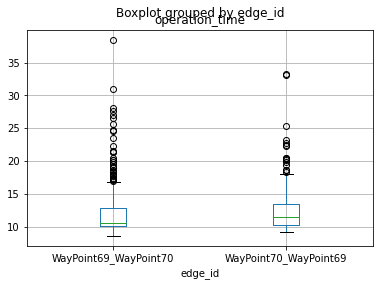

In [11]:
subset.boxplot(column = "operation_time", by = "edge_id")

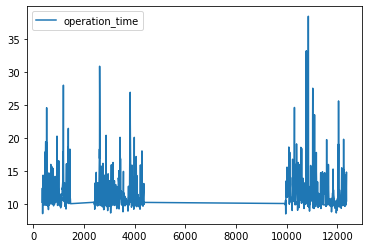

In [12]:
subset.plot()

# 2) Gaussian
- Bad: Gives non-zero probability to impossible events

## 2ai) Frequentist approach
- on a subset of the full dataset (so that we can use the sequential updates in 2aii)

In [13]:
def Gaussian_ml(t):
    "Calculate max. likelihood estimators of Gaussian"
    N = len(t)
    mean_ml = (1/N) * np.sum(t)
    var_ml = (1/N) * np.sum(np.square(t - mean_ml))
    return mean_ml, var_ml

In [14]:
def Gaussian(x,mean,var):
    "Calculate gaussian distribution"
    return ( 1/ ((2*np.pi*var)**0.5) )*np.exp( (-1/(2*var)) * np.square(x-mean) )

In [15]:
#find mean & variance
t_op = subset["operation_time"]
mean_ml, var_ml = Gaussian_ml(t_op[0:len(t_op)//3])
print(mean_ml, var_ml)

12.232456 10.208620984064002


In [16]:
# calculate distribution
t_start= 0
t_stop = (np.max(t_op)//5)*5 + 5    #round up to nearest 5 secs
t_step = 0.01
t = np.arange(t_start,t_stop,t_step)
p = Gaussian(t,mean_ml,var_ml)

Text(0.5, 1.0, 'WayPoint69_WayPoint70')

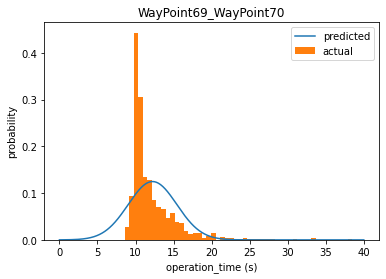

In [17]:
plt.plot(t,p)
plt.hist(t_op, density = True, bins = 50)
plt.legend(["predicted","actual"])
plt.xlabel("operation_time (s)")
plt.ylabel("probability")
plt.title(subset.iloc[0,0])

## 2aii) Frequentist - sequential updates
- Online updates
- We are using SAMPLE mean & variance, which is why the algorithms are slightly different from wikipedia

In [18]:
def update_mean(mean, n, t_new):
    """Sequential update of Gaussian MLE for mean (Bishop 2.3.5)
    The input mean has been previously calculated for n = N-1 terms
    n is the number of terms considered in the calculation of the previous mean
    We update using the new observation t_new
    Key weakness: new data gets progressively less powerful in changing the mean
    """
    N = n+1
    return mean + (1/N)*(t_new - mean)

In [19]:
def update_var(mean, var, n, t_new):
    """Sequential update of Gaussian MLE for sample variance 
    mean & var are the MLE mean & variance for n = N-1 samples
    n is the number of terms considered in the calculation of the previous mean
    We update using the new observation t_new
    Key weakness: new data gets progressively less powerful in changing the var
    """
    N = n+1
    return ( (N-1)/N ) * var + ( (t_new - mean)**2 )/N

In [20]:
#We calculate mean & variance of a subset of the data as in 2ai)
#find mean & variance
t_op = subset["operation_time"]
n_terms = len(t_op)//3
mean_ml, var_ml = Gaussian_ml(t_op[0:n_terms])
print(mean_ml, var_ml)

12.232456 10.208620984064002


In [21]:
# now update with the other values
for n in range(n_terms, len(t_op)):
    t_new = float(t_op[n:n+1])      #new value
    
    mean_ml = update_mean(mean_ml, n, t_new)
    var_ml = update_var(mean_ml, var_ml, n, t_new)

print("mean:", mean_ml, "    var:", var_ml)

mean: 12.154848202396817     var: 11.400758137907605


In [100]:
#check with non_sequential method
t_op = subset["operation_time"]
mean_check, var_check = Gaussian_ml(t_op)
print("Check:",mean_check, var_check)

Check: 12.154848202396805 11.417793641404893


Mathematically, both methods should be equivalent. <br>
We find that the mean is the same, but the variance has a slight difference between the all-at-once and sequential methods. <br>
I assume this is due to accumulation of rounding error between sequential updates

## 2bi) Bayesian Approach - simple
- Assume var known, mean unknown
- estimate var using MLE

In [84]:
#prior
def prior_1(mean, mean_0, var_0):
    "mean is a guess. mean_0 & var_0 are parameters"
    return Gaussian(mean,mean_0,var_0)



In [85]:
def likelihood_1(t,mean):
    N = len(t)
    var = (1/N) * np.sum((t - mean)**2)
    log_likelihood = 0
    for n in range(len(t)):
        likelihood = Gaussian(t.iloc[n],mean,var)
        log_likelihood += np.log(likelihood)
    return log_likelihood


%timeit prior_1(13,12,12)
%timeit likelihood_1(t_op,13)
np.exp(likelihood_1(t_op,13))*prior_1(13,12,12)

5.99 µs ± 380 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
11.4 ms ± 516 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


0.0

In [86]:
t_start= 0
t_stop = (np.max(t_op)//5)*5 + 5    #round up to nearest 5 secs
t_step = 0.01
mu = np.arange(t_start,t_stop,t_step)
print(mu, len(mu))


[0.000e+00 1.000e-02 2.000e-02 ... 3.997e+01 3.998e+01 3.999e+01] 4000


In [87]:
mean_0 = 3
var_0 = 4
prior_list = []
likelihood_list = []
for m in mu:
    prior_list.append(prior_1(m,mean_0,var_0))
    likelihood_list.append(likelihood_1(t_op,m))
print("done")

done


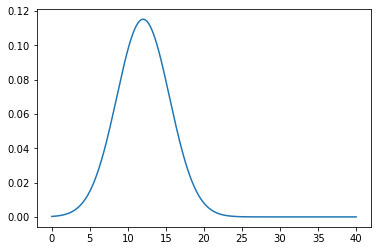

In [35]:
plt.plot(mu,prior_list)

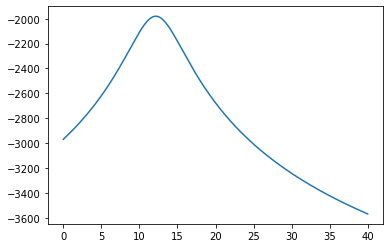

In [36]:
plt.plot(mu,likelihood_list)

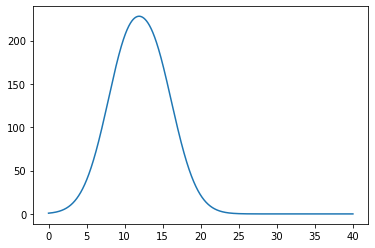

In [37]:
#WRONG posterior
#posterior = log(normal) likelihood * normal prior
posterior_list = np.multiply(prior_list,np.abs(likelihood_list))
plt.plot(mu,posterior_list)

0.01 2186.3103789104634


Text(0.5, 1.0, 'WayPoint69_WayPoint70')

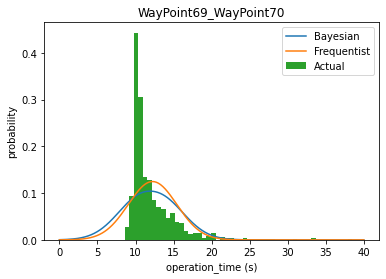

In [38]:
#normalise a distribution
spacing = mu[1]-mu[0]
norm_const = spacing * np.sum(posterior_list)
print(spacing, norm_const)
plt.plot(mu,posterior_list/norm_const)
plt.plot(t,p)
plt.hist(t_op, density = True, bins = 50)
plt.legend(["Bayesian", "Frequentist","Actual"])
plt.xlabel("operation_time (s)")
plt.ylabel("probability")
plt.title(subset.iloc[0,0])

## 2bii) Bayesian - sequential updates
- Assume var known (estimate using MLE), mean unknown

In [39]:
#prior
def prior_2(mean, mean_0, var_0):
    """mean is a guess. mean_0 & var_0 are parameters of Gaussian prior"""
    return Gaussian(mean,mean_0,var_0)

In [40]:
def likelihood_2(t,mean,var):
    """ Sequential update to likelihood (i.e. t is a single value)"""
    return Gaussian(t,mean,var)

In [41]:
#define a range of means to test
t_start= 0
t_stop = (np.max(t_op)//5)*5 + 5    #round up to nearest 5 secs
t_step = 0.001
mean_test = np.arange(t_start,t_stop,t_step)
print(mean_test, mean_test)

[0.0000e+00 1.0000e-03 2.0000e-03 ... 3.9997e+01 3.9998e+01 3.9999e+01] [0.0000e+00 1.0000e-03 2.0000e-03 ... 3.9997e+01 3.9998e+01 3.9999e+01]


[1.09812838e-03 1.09912365e-03 1.10011973e-03 ... 2.02050924e-18
 2.01525752e-18 2.01001928e-18]
0.1649969130622838 11143 11.143


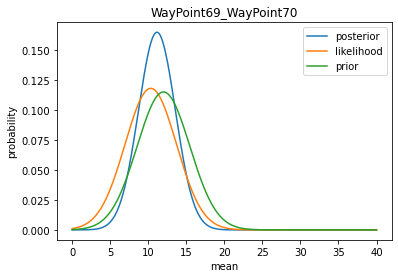

In [102]:
#create Gaussian prior
mean_0 = 12
var_0 = 12
prior = prior_2(mean_test,mean_0,var_0)

#calculate likelihood from known variance
var = 11.4
t_new = float(t_op[0:1])
likelihood = likelihood_2(t_new,mean_test,var)
print(likelihood)
#Bayes rule
posterior = prior*likelihood
#normalise the distribution
spacing = mean_test[1]-mean_test[0]
norm_const = spacing * np.sum(posterior)
posterior /= norm_const

#plot
plt.plot(mean_test,posterior)
plt.plot(mean_test,likelihood)
plt.plot(mean_test,prior)
plt.legend(["posterior","likelihood","prior"])
plt.xlabel("mean")
plt.ylabel("probability")
plt.title(subset.iloc[0,0])

print(np.max(posterior), np.argmax(posterior), mean_test[np.argmax(posterior)])

0.44315487612663257


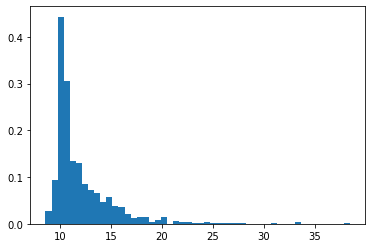

In [103]:
#find max value of a histogram - no longer useful
y, x, _ = plt.hist(t_op, density = True, bins = 50)
p_max = max(y)
print(p_max)

In [104]:
#successive updates
for n in range(1, len(t_op)//5):
    #test
    if np.max(posterior) > 0.9:
        print(n-1)
        break
    
    t_new = float(t_op[n:n+1])      #new value
    likelihood = likelihood_2(t_new,mean_test,var)
    #Bayes rule
    posterior = posterior*likelihood
    #normalise the distribution
    spacing = mean_test[1]-mean_test[0]
    norm_const = spacing * np.sum(posterior)
    posterior /= norm_const
print("done", norm_const, spacing, np.max(posterior), np.sum(posterior))

57
done 0.09758161176442175 0.001 0.9071926906907711 999.9999999999999


0.9071926906907711 12395 12.395


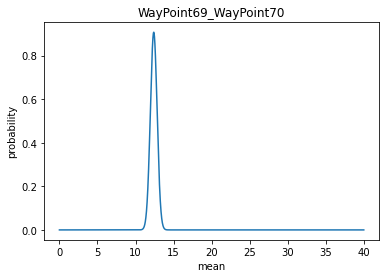

In [105]:
#plot
plt.plot(mean_test,posterior)

plt.xlabel("mean")
plt.ylabel("probability")
plt.title(subset.iloc[0,0])

print(np.max(posterior), np.argmax(posterior), mean_test[np.argmax(posterior)])

Issue resolved: This finds the MAP estimate of the MEAN, from which we can plot the Gaussian that describes the distribution

In [106]:
t_op.describe()

count    751.000000
mean      12.154848
std        3.381275
min        8.559000
25%       10.153000
50%       10.891000
75%       13.132500
max       38.456000
Name: operation_time, dtype: float64

0.9071926906907711 12395 12.395


Text(0.5, 1.0, 'WayPoint69_WayPoint70')

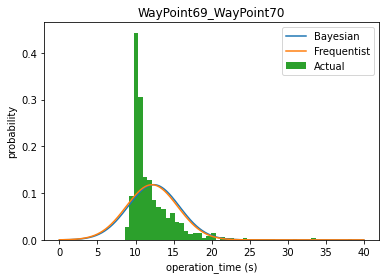

In [107]:
posterior_max = np.max(posterior)
posterior_index = np.argmax(posterior)
mean_map = mean_test[posterior_index]
print(posterior_max, posterior_index,mean_map)
posterior_likelihood = Gaussian(t,mean_map,var)
#Frequentist
t_freq = Gaussian(t,mean_check, var_check)
#plot
plt.plot(t,posterior_likelihood)
plt.plot(t,t_freq)
plt.hist(t_op, density = True, bins = 50)
plt.legend(["Bayesian","Frequentist", "Actual"])
plt.xlabel("operation_time (s)")
plt.ylabel("probability")
plt.title(subset.iloc[0,0])